# Hyper Parameter Tuning 

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import kerastuner as kt # for tuning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras import regularizers

In [64]:
df = pd.read_csv('diabetes.csv')
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.6839137 , -0.70579433, -0.625833  , ...,  0.26501306,
        -0.11390738,  0.87654579],
       [-0.52726014, -0.26972894,  0.29889263, ...,  0.48823955,
        -0.94569142, -1.03690611],
       [-0.52726014, -0.39431905, -0.29945925, ..., -0.15517797,
        -0.91619553, -1.03690611],
       ...,
       [ 0.6839137 ,  0.07289387,  0.13570575, ...,  0.21248918,
         0.77981801,  0.09377001],
       [-0.22446668, -1.32874488, -1.06099801, ..., -0.12891603,
        -0.65073254, -0.60203068],
       [-0.22446668, -0.45661411,  0.13570575, ..., -0.81172646,
        -0.77166568, -0.51505559]])

In [65]:
def build_hyper_model(hp):
    model = Sequential()

    counter = 0

    for i in range(hp.Int('num_layers',min_value = 1,max_value = 10)):
        if counter == 0:
            model.add(
                Dense(
                units = hp.Int('num_nodes'+str(i),min_value=8,max_value = 128,step=8),
                activation = hp.Choice('activation'+str(i),values = ['tanh','relu','elu']),
                input_dim = 8,
                name = 'input_layer-'+str(i)
                )
            )
        else:
            model.add(
                Dense(
                units = hp.Int('num_node'+str(i),min_value = 8,max_value = 128,step=8),
                activation = hp.Choice('activaton'+str(i),values = ['tanh','relu','elu']),
                name = 'Middle_layer-'+str(i)),
                kernel_regularizer = regularizers.L2(.02)
            )
        counter+=1

    model.add(
        Dense(
        units = 1,
        activation = 'sigmoid',
        name= 'Output_layer')
    )

    model.compile(
        optimizer = hp.Choice('optimizer',values = ['rmsprop','adam','sdg','nadam']),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
        )

    return model
        

In [66]:
tuner = kt.RandomSearch(hypermodel=build_hyper_model,
                        objective='val_accuracy',
                        max_trials=3,
                        directory = 'tuner',
                        project_name = 'Hyper_modelwithAllBestParameters')


In [67]:
tuner.search(X_train,y_train,epochs = 5,validation_data = (X_test,y_test))

Trial 3 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.5572916865348816
Total elapsed time: 00h 00m 03s
INFO:tensorflow:Oracle triggered exit


In [68]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 1,
 'num_nodes0': 40,
 'activation0': 'elu',
 'optimizer': 'adam',
 'num_node1': 48,
 'activaton1': 'elu'}

In [69]:
model = tuner.get_best_models()[0]
model

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer-0 (Dense)       (None, 40)                360       
                                                                 
 Output_layer (Dense)        (None, 1)                 41        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(
        x=X_train,
        y=y_train,
        batch_size = 32,
        epochs=100,
        validation_data= (X_test,y_test),
        )

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 3.2534 - accuracy: 0.5330 - val_loss: 2.9164 - val_accuracy: 0.5521
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 2.7066 - accuracy: 0.5156 - val_loss: 2.4109 - val_accuracy: 0.5625
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 2.2420 - accuracy: 0.5139 - val_loss: 2.0073 - val_accuracy: 0.5469
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 1.8790 - accuracy: 0.5191 - val_loss: 1.8134 - val_accuracy: 0.5833
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 1.6339 - accuracy: 0.5174 - val_loss: 1.6200 - val_accuracy: 0.6042
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 1.4237 - accuracy: 0.5347 - val_loss: 1.3551 - val_accuracy: 0.6250
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 1.2664 - accuracy: 0.5590 - val_loss: 1.2841 - val_accuracy: 0.5469
Epoch 8/100


In [72]:
history.history['val_accuracy'][99]

0.7239583134651184

Text(0.5, 1.0, 'val_loss- 0.585 and loss- 0.499')

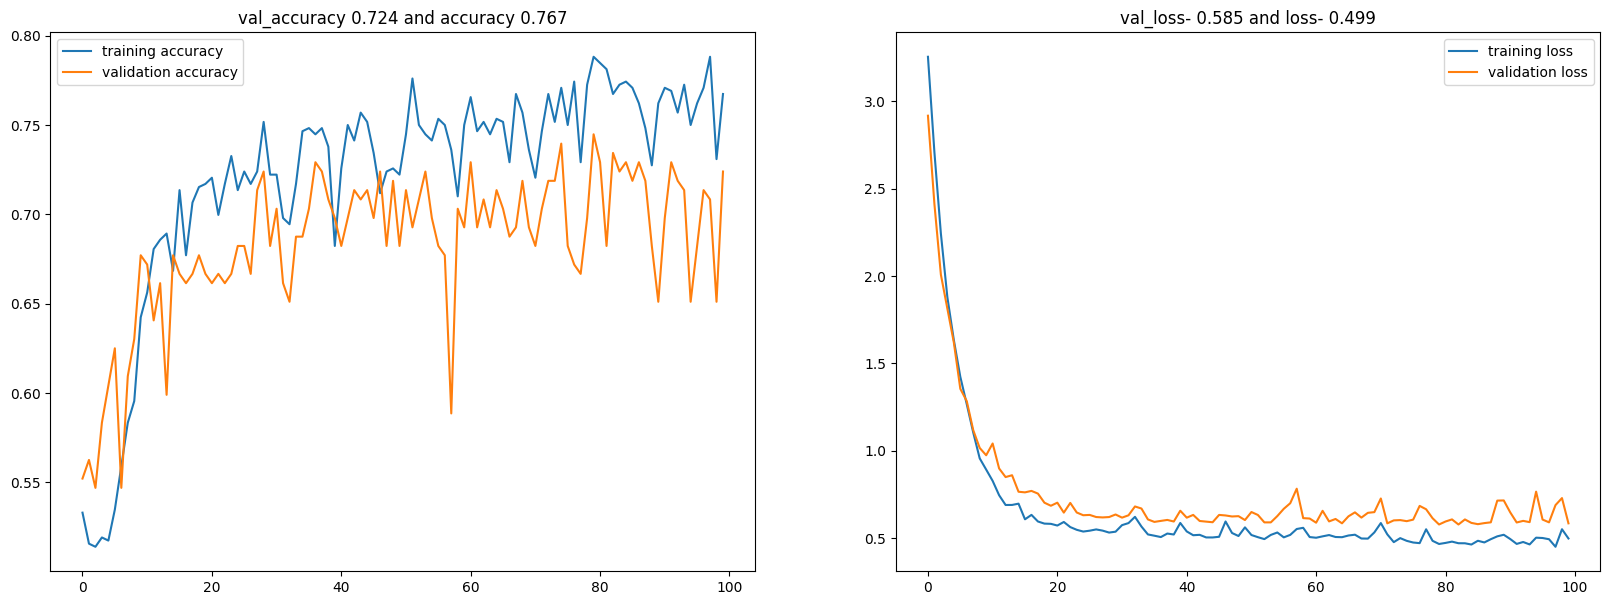

In [73]:
plt.subplots(nrows=1,ncols=2,figsize = (20,7))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training accuracy','validation accuracy'])
plt.title(f'val_accuracy {round(history.history["val_accuracy"][99],ndigits=3)} and accuracy {round(history.history["accuracy"][99],ndigits=3)}')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title(f'val_loss- {round(history.history["val_loss"][99],ndigits=3)} and loss- {round(history.history["loss"][99],ndigits=3)}')
